In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from knn_colors import knn_fit, getTrueY

In [2]:
unp = Table.read("unperturbed_mags.fits")

In [3]:
unp.info

<Table length=698211>
       name         dtype  unit    class     n_bad
------------------ ------- ---- ------------ -----
                ID   int64      MaskedColumn     0
                RA float64  deg       Column     0
               DEC float64  deg       Column     0
        ID_CLASSIC   int64      MaskedColumn     1
            photoz float64            Column     0
           lp_type   int64      MaskedColumn     0
         lp_NbFilt   int64      MaskedColumn     0
             lp_zq float64            Column     0
          lp_model   int64      MaskedColumn     0
            lp_age float64            Column     0
           lp_dust float64            Column     0
    lp_Attenuation   int64      MaskedColumn     0
       lp_mass_med float64            Column     0
      lp_mass_best float64            Column     0
        lp_SFR_med float64            Column     0
       lp_SFR_best float64      MaskedColumn   511
       lp_sSFR_med float64      MaskedColumn    23
      lp_

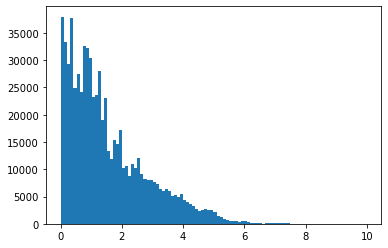

In [4]:
plt.hist(unp["photoz"], bins=100)
plt.show()

In [5]:
mock = Table.read("ext_phot.fits")
mask = unp["Euclid_VIS_MAG"] <= 24.5

In [6]:
# lets do some photo-z fitting using knn method
# use unperturbed catalog as training set
# split in half so half the objects are for training, and half for test

train = unp[mask]
test = mock[mask]

rng = np.random.default_rng(seed=42)
random_ids = np.arange(len(train))
rng.shuffle(random_ids)
split_dex = int(len(train) / 2)

train = train[random_ids[0:split_dex]]
test = test[random_ids[split_dex:]]

print(len(test))

58221


In [7]:
# LSST griz and Euclid JH
mag_columns = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "Euclid_J_MAG", "Euclid_H_MAG"]

estz = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns, y_col_name="photoz")
truez = getTrueY(test_cat=test, mag_col_names=mag_columns, y_col_name="photoz")

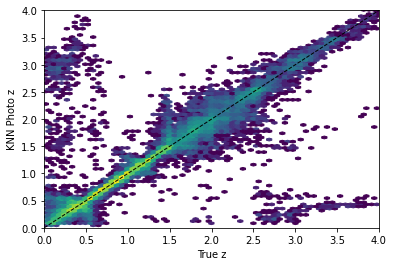

In [8]:
plt.hexbin(truez, estz, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [9]:
# define photo-z summary statistics

def sigma(z_est, z_true, N):
    numerator = (z_est - z_true)
    denominator = (1+z_true)
    summand = (numerator/denominator)**2
    summed = np.sum(summand)
    return 1/N * summed

def bias(z_est, z_true, N):
    summand = (z_est - z_true)
    summed = np.sum(summand)
    return 1/N * summed

def abs_bias(z_est, z_true, N):
    summand = np.abs(z_est - z_true)
    summed = np.sum(summand)
    return 1/N * summed

In [10]:
sig = sigma(estz, truez, len(estz))

b = bias(estz, truez, len(estz))

a_b = abs_bias(estz, truez, len(estz))

In [13]:
good = np.abs(estz - truez) < 5*sig
bad = np.abs(estz - truez) > 5*sig

In [14]:
good

array([ True,  True,  True, ...,  True,  True,  True])

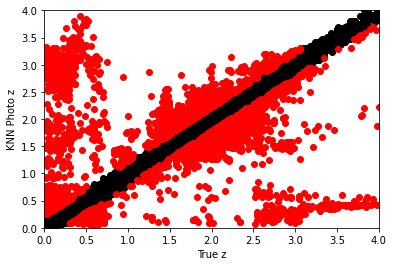

In [15]:
plt.scatter(truez[good], estz[good], color = 'k')
plt.scatter(truez[bad], estz[bad], color = 'r')

plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [19]:
# LSST + CASTOR 
mag_columns_castor_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "castor_uv_MAG", "castor_u_MAG", "castor_g_MAG"]

estz_LSST_Castor = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")
truez_LSST_Castor = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")

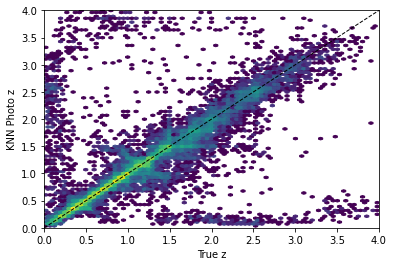

In [20]:
plt.hexbin(truez_LSST_Castor, estz_LSST_Castor, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [21]:
# LSST 
mag_columns_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG"]

estz_LSST = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="photoz")
truez_LSST = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="photoz")

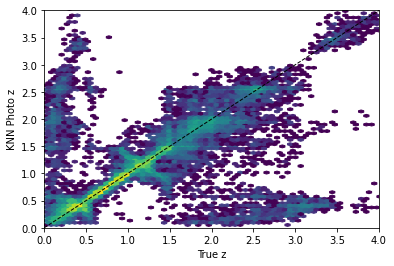

In [22]:
plt.hexbin(truez_LSST, estz_LSST, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [26]:
sig = sigma(estz_LSST, truez_LSST, len(estz))

b = bias(estz_LSST, truez_LSST, len(estz))

a_b = abs_bias(estz_LSST, truez_LSST, len(estz))

print(sig, b, a_b)

0.08661546805800022 -0.02219707081091997 0.19770702142503074


In [27]:
sig = sigma(estz_LSST_Castor, truez_LSST_Castor, len(estz))

b = bias(estz_LSST_Castor, truez_LSST_Castor, len(estz))

a_b = abs_bias(estz_LSST_Castor, truez_LSST_Castor, len(estz))

print(sig, b, a_b)

0.04404638715290214 0.0009265921900530586 0.10334875341937617
